# The Battle of Neighborhoods

### Submitted By Muhammad Rehan

## Introduction

In this notebook, we will learn how to convert addresses into their equivalent latitude and longitude values. Also, we will use the Foursquare API to explore Islamabad and Lahore. The Folium library will be used to visualize the spots on map.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download, Scrapping and Applying EDA on Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Toronto</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#Beautiful Soup is a Python library for pulling data out of HTML and XML files.
!pip install beautifulsoup4
from bs4 import BeautifulSoup

!pip install lxml
import lxml

#The content type is normally handled by Requests so you can access the data that gets returned
import requests 

import seaborn as sns
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Download, Scrapping and Applying EDA on Dataset

In [3]:
Isl_address = 'Islamabad, Pakistan'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(Isl_address)
Isl_latitude = location.latitude
Isl_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(Isl_address,Isl_latitude, Isl_longitude))

The geograpical coordinate of Islamabad, Pakistan are 33.6938118, 73.0651511.


In [4]:
CLIENT_ID = 'D13G4BNF2CYNDJQPLAIPKLNZJM4OG5DG0CE13QVQTH2WFLCF' # your Foursquare ID
CLIENT_SECRET = 'OJXVEOLE2KYEYPZR34SGA4WUIRE1UTGP0C4VJYOUKA1YRJU5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D13G4BNF2CYNDJQPLAIPKLNZJM4OG5DG0CE13QVQTH2WFLCF
CLIENT_SECRET:OJXVEOLE2KYEYPZR34SGA4WUIRE1UTGP0C4VJYOUKA1YRJU5


In [5]:
### important
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 50000 # define radius

Isl_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Isl_latitude, 
    Isl_longitude, 
    radius, 
    LIMIT)
Isl_url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=D13G4BNF2CYNDJQPLAIPKLNZJM4OG5DG0CE13QVQTH2WFLCF&client_secret=OJXVEOLE2KYEYPZR34SGA4WUIRE1UTGP0C4VJYOUKA1YRJU5&v=20180605&ll=33.6938118,73.0651511&radius=50000&limit=1000'

In [6]:
Isl_results = requests.get(Isl_url).json()
#results

In [7]:
#Isl_results

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [9]:
venues = Isl_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.address']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.fillna(value= 'Islamabad',inplace=True)
nearby_venues

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,address
0,Pakistan Monument,History Museum,33.693070,73.068910,Islamabad
1,Burning Brownie Cafe & Bake Shop,Coffee Shop,33.720508,73.073956,"Shop # 66, Beverly Centre"
2,Lok Virsa Museum,History Museum,33.688942,73.072550,Garden avenue
3,D.Watson,Pharmacy,33.696279,73.012849,"10th Avenue, F-10 Markaz"
4,Chaaye Khana,Tea Room,33.729388,73.074913,"Shop # 11, Block-B, United Bakery Plaza, F-6 M..."
5,Tehzeeb Bakers,Bakery,33.715444,73.067963,"81, Blue Area, Jinnah Avenue"
6,Monal,Pakistani Restaurant,33.760033,73.065770,Pir Sohawa
7,Shinwari,BBQ Joint,33.685101,73.042721,Islamabad
8,Doka Mocca,Snack Place,33.698124,73.050180,"Unit # 14 & 15, Block 12- D, G-8 Markaz, Near ..."
9,Islamabad Club,Golf Course,33.704615,73.105589,Murree Road


In [11]:
Isl_nearby_venues =nearby_venues.copy()
Isl_nearby_venues.head()

,name,categories,lat,lng,address
0,Pakistan Monument,History Museum,33.693070,73.068910,Islamabad
1,Burning Brownie Cafe & Bake Shop,Coffee Shop,33.720508,73.073956,"Shop # 66, Beverly Centre"
2,Lok Virsa Museum,History Museum,33.688942,73.072550,Garden avenue
3,D.Watson,Pharmacy,33.696279,73.012849,"10th Avenue, F-10 Markaz"
4,Chaaye Khana,Tea Room,33.729388,73.074913,"Shop # 11, Block-B, United Bakery Plaza, F-6 M..."


In [10]:
set(nearby_venues.categories)

{'Asian Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bookstore',
 'Boutique',
 'Burger Joint',
 'Café',
 'Coffee Shop',
 'Department Store',
 'Fast Food Restaurant',
 'Food Court',
 'Gift Shop',
 'Golf Course',
 'Gym',
 'History Museum',
 'Hotel',
 'Ice Cream Shop',
 'Italian Restaurant',
 'Lake',
 'Market',
 'Mountain',
 'Multiplex',
 'Nature Preserve',
 'Other Great Outdoors',
 'Pakistani Restaurant',
 'Park',
 'Pharmacy',
 'Pizza Place',
 'Restaurant',
 'Sandwich Place',
 'Scenic Lookout',
 'Shopping Mall',
 'Snack Place',
 'Tea Room',
 'Theater',
 'Trail',
 'Wings Joint'}

In [16]:
dic = {'Asian Restaurant' : 'Food Lover',
 'BBQ Joint' : 'Food Lover',
 'Bakery' : 'Food Lover',
 'Bookstore': 'Shopping',
 'Boutique' : 'Shopping',
 'Burger Joint': 'Food Lover',
 'Café': 'Food Lover',
 'Coffee Shop': 'Food Lover',
 'Department Store' : 'Shopping',
 'Fast Food Restaurant': 'Food Lover',
 'Food Court': 'Food Lover',
 'Gift Shop' : 'Shopping',
 'Golf Course': 'Recreational',
 'Gym': 'Health',
 'History Museum': 'Recreational',
 'Hotel': 'Hotel',
 'Ice Cream Shop': 'Food Lover',
 'Italian Restaurant': 'Food Lover',
 'Lake': 'Recreational',
 'Market' : 'Shopping',
 'Mountain': 'Recreational',
 'Multiplex': 'Recreational',
 'Nature Preserve': 'Recreational',
 'Other Great Outdoors': 'Recreational',
 'Pakistani Restaurant': 'Food Lover',
 'Park': 'Recreational',
 'Pharmacy': 'Health',
 'Pizza Place': 'Food Lover',
 'Restaurant': 'Food Lover',
 'Sandwich Place': 'Food Lover',
 'Scenic Lookout': 'Recreational',
 'Shopping Mall' : 'Shopping',
 'Snack Place': 'Food Lover',
 'Tea Room': 'Food Lover',
 'Theater': 'Recreational',
 'Trail': 'Recreational',
 'Wings Joint': 'Food Lover'}

In [17]:
Isl_nearby_venues['New Cat']= Isl_nearby_venues.categories
for i,name in enumerate(Isl_nearby_venues['New Cat']):
    Isl_nearby_venues['New Cat'][i] = dic[name]
Isl_nearby_venues.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,address,New Cat
0,Pakistan Monument,History Museum,33.693070,73.068910,Islamabad,Recreational
1,Burning Brownie Cafe & Bake Shop,Coffee Shop,33.720508,73.073956,"Shop # 66, Beverly Centre",Food Lover
2,Lok Virsa Museum,History Museum,33.688942,73.072550,Garden avenue,Recreational
3,D.Watson,Pharmacy,33.696279,73.012849,"10th Avenue, F-10 Markaz",Health
4,Chaaye Khana,Tea Room,33.729388,73.074913,"Shop # 11, Block-B, United Bakery Plaza, F-6 M...",Food Lover


In [45]:
map_Isl = folium.Map(location=[Isl_latitude, Isl_longitude], zoom_start=11)
col= 'white'
# add markers to map
for lat, lng, address, name, cat in zip(Isl_nearby_venues['lat'], Isl_nearby_venues['lng'], Isl_nearby_venues['address'], Isl_nearby_venues['name'], Isl_nearby_venues['New Cat']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    if cat == 'Food Lover':
        col = 'blue'
    elif cat=='Recreational':
        col= 'orange'
    elif cat== 'Shopping':
        col = 'green'
    elif cat == 'Health':
        col = 'red'
    elif cat == 'Hotel':
        col = 'purple'
    else:
        col = 'black'

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= col,
        fill=True,
        fill_color=col, #'#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_Isl)  
    
map_Isl

In [46]:
Isl_NewCat_percentage = Isl_nearby_venues['New Cat'].value_counts(normalize= True).reset_index()
Isl_NewCat_percentage['Percentage']= Isl_NewCat_percentage['New Cat']*100
Isl_NewCat_percentage

,index,New Cat,Percentage
0,Food Lover,0.555556,55.555556
1,Recreational,0.206349,20.634921
2,Shopping,0.126984,12.698413
3,Health,0.063492,6.349206
4,Hotel,0.047619,4.761905


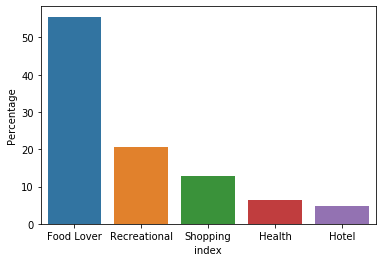

In [47]:
#plt.figure(figsize= (20,6))
sns.barplot(x='index', y='Percentage', data=Isl_NewCat_percentage, dodge=True);

And how many venues were returned by Foursquare?

In [48]:
print('{} venues were returned by Foursquare.'.format(Isl_nearby_venues.shape[0]))

63 venues were returned by Foursquare.


In [49]:
Lhr_address = 'Lahore, Pakistan'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(Lhr_address)
Lhr_latitude = location.latitude
Lhr_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(Lhr_address,Lhr_latitude, Lhr_longitude))

The geograpical coordinate of Lahore, Pakistan are 31.5656079, 74.3141775.


In [23]:
### important
Lhr_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Lhr_latitude, 
    Lhr_longitude, 
    radius, 
    LIMIT)
Lhr_url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=D13G4BNF2CYNDJQPLAIPKLNZJM4OG5DG0CE13QVQTH2WFLCF&client_secret=OJXVEOLE2KYEYPZR34SGA4WUIRE1UTGP0C4VJYOUKA1YRJU5&v=20180605&ll=31.5656079,74.3141775&radius=50000&limit=1000'

In [24]:
Lhr_results = requests.get(Lhr_url).json()
#results

In [25]:
#Lhr_results

In [50]:
venues = Lhr_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.address']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.fillna(value= 'Lahore',inplace=True)
nearby_venues

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,address
0,Minar-e-Pakistan,Monument / Landmark,31.591604,74.309481,Circular Rd
1,Fort Food Street,Food Court,31.587092,74.311538,Fort Rd
2,Badshahi Masjid,Mosque,31.588195,74.311354,Shahi Mohalla
3,Jalal Sons,Department Store,31.523956,74.345706,12-E Main Market
4,Tuscany Courtyard,Italian Restaurant,31.519804,74.351510,MM Alam Road
5,Spice Bazar,Pakistani Restaurant,31.518703,74.354930,"T-01, Off MM Alam Road, Block T, Gulberg 2"
6,Haveli,Pakistani Restaurant,31.586986,74.311349,Badshahi Mosque
7,Fort View,Restaurant,31.587374,74.312010,Lahore
8,باغ جناح,Park,31.553507,74.330380,Mall Road - Old
9,Model Town Park,Park,31.484509,74.326320,Model Town


In [51]:
Lhr_nearby_venues =nearby_venues.copy()
Lhr_nearby_venues.head()

,name,categories,lat,lng,address
0,Minar-e-Pakistan,Monument / Landmark,31.591604,74.309481,Circular Rd
1,Fort Food Street,Food Court,31.587092,74.311538,Fort Rd
2,Badshahi Masjid,Mosque,31.588195,74.311354,Shahi Mohalla
3,Jalal Sons,Department Store,31.523956,74.345706,12-E Main Market
4,Tuscany Courtyard,Italian Restaurant,31.519804,74.351510,MM Alam Road


In [52]:
set(Lhr_nearby_venues.categories)

{'American Restaurant',
 'Asian Restaurant',
 'Bakery',
 'Bookstore',
 'Boutique',
 'Burger Joint',
 'Café',
 'Chinese Restaurant',
 'Coffee Shop',
 'Convenience Store',
 'Department Store',
 'Fast Food Restaurant',
 'Fish & Chips Shop',
 'Food Court',
 'Food Truck',
 'Golf Course',
 'Gym / Fitness Center',
 'Hotel',
 'Ice Cream Shop',
 'Indian Restaurant',
 'Italian Restaurant',
 'Market',
 'Mediterranean Restaurant',
 'Middle Eastern Restaurant',
 'Monument / Landmark',
 'Mosque',
 'Movie Theater',
 'Multiplex',
 'Pakistani Restaurant',
 'Park',
 'Pizza Place',
 'Portuguese Restaurant',
 'Recreation Center',
 'Rest Area',
 'Restaurant',
 'Shopping Mall',
 'Spa',
 'Steakhouse',
 'Tea Room',
 'Theater'}

In [53]:
dic2={'American Restaurant': 'Food Lover',
 'Asian Restaurant': 'Food Lover',
 'Bakery': 'Food Lover',
 'Bookstore' : 'Shopping',
 'Boutique' : 'Shopping',
 'Burger Joint': 'Food Lover',
 'Café': 'Food Lover',
 'Chinese Restaurant': 'Food Lover',
 'Coffee Shop': 'Food Lover',
 'Convenience Store' : 'Shopping',
 'Department Store' : 'Shopping',
 'Fast Food Restaurant': 'Food Lover',
 'Fish & Chips Shop': 'Food Lover',
 'Food Court': 'Food Lover',
 'Food Truck': 'Food Lover',
 'Golf Course': 'Food Lover',
 'Gym / Fitness Center': 'Health',
 'Hotel':'Hotel',
 'Ice Cream Shop': 'Food Lover',
 'Indian Restaurant': 'Food Lover',
 'Italian Restaurant': 'Food Lover',
 'Market' : 'Shopping',
 'Mediterranean Restaurant': 'Food Lover',
 'Middle Eastern Restaurant': 'Food Lover',
 'Monument / Landmark': 'Recreational',
 'Mosque':'Mosque',
 'Movie Theater':'Recreational',
 'Multiplex': 'Recreational',
 'Pakistani Restaurant': 'Food Lover',
 'Park': 'Recreational',
 'Pizza Place': 'Food Lover',
 'Portuguese Restaurant': 'Food Lover',
 'Recreation Center':'Recreational',
 'Rest Area': 'Hotel',
 'Restaurant': 'Food Lover',
 'Shopping Mall' : 'Shopping',
 'Spa': 'Health',
 'Steakhouse': 'Food Lover',
 'Tea Room': 'Food Lover',
 'Theater': 'Recreational'}

In [54]:
Lhr_nearby_venues['New Cat']= Lhr_nearby_venues.categories
for i,name in enumerate(Lhr_nearby_venues['New Cat']):
    Lhr_nearby_venues['New Cat'][i] = dic2[name]
Lhr_nearby_venues.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,address,New Cat
0,Minar-e-Pakistan,Monument / Landmark,31.591604,74.309481,Circular Rd,Recreational
1,Fort Food Street,Food Court,31.587092,74.311538,Fort Rd,Food Lover
2,Badshahi Masjid,Mosque,31.588195,74.311354,Shahi Mohalla,Mosque
3,Jalal Sons,Department Store,31.523956,74.345706,12-E Main Market,Shopping
4,Tuscany Courtyard,Italian Restaurant,31.519804,74.351510,MM Alam Road,Food Lover


In [55]:
Lhr_NewCat_percentage = Lhr_nearby_venues['New Cat'].value_counts(normalize= True).reset_index()
Lhr_NewCat_percentage['Percentage']= Lhr_NewCat_percentage['New Cat']*100
Lhr_NewCat_percentage

,index,New Cat,Percentage
0,Food Lover,0.682353,68.235294
1,Shopping,0.129412,12.941176
2,Recreational,0.129412,12.941176
3,Hotel,0.023529,2.352941
4,Health,0.023529,2.352941
5,Mosque,0.011765,1.176471


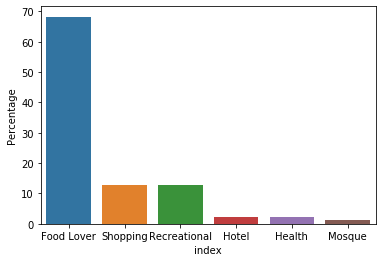

In [56]:
#plt.figure(figsize= (20,6))
sns.barplot(x='index', y='Percentage', data=Lhr_NewCat_percentage, dodge=True);

And how many venues were returned by Foursquare?

In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

85 venues were returned by Foursquare.


In [57]:
map_Lhr = folium.Map(location=[Lhr_latitude, Lhr_longitude], zoom_start=11)

# add markers to map
for lat, lng, address, name, cat in zip(Lhr_nearby_venues['lat'], Lhr_nearby_venues['lng'], Lhr_nearby_venues['address'], Lhr_nearby_venues['name'], Lhr_nearby_venues['New Cat']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    if cat == 'Food Lover':
        col = 'blue'
    elif cat=='Recreational':
        col= 'green'
    elif cat== 'Shopping':
        col = 'orange'
    elif cat == 'Health':
        col = 'purple'
    elif cat == 'Hotel':
        col = 'red'
    else:
        col = 'black'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color= col,
        fill_opacity=0.2,
        parse_html=False).add_to(map_Lhr)  
    
map_Lhr

# Comparison

In [105]:
cmp = Lhr_nearby_venues["New Cat"].value_counts().reset_index()
cmp['lhr'] = cmp['New Cat']
del(cmp['New Cat'])
cmp

,index,lhr
0,Food Lover,58
1,Shopping,11
2,Recreational,11
3,Hotel,2
4,Health,2
5,Mosque,1


In [106]:
c = Isl_nearby_venues["New Cat"].value_counts().reset_index()
cmp['isl'] = c['New Cat']
cmp.fillna(value=0)

,index,lhr,isl
0,Food Lover,58,35.0
1,Shopping,11,13.0
2,Recreational,11,8.0
3,Hotel,2,4.0
4,Health,2,3.0
5,Mosque,1,0.0


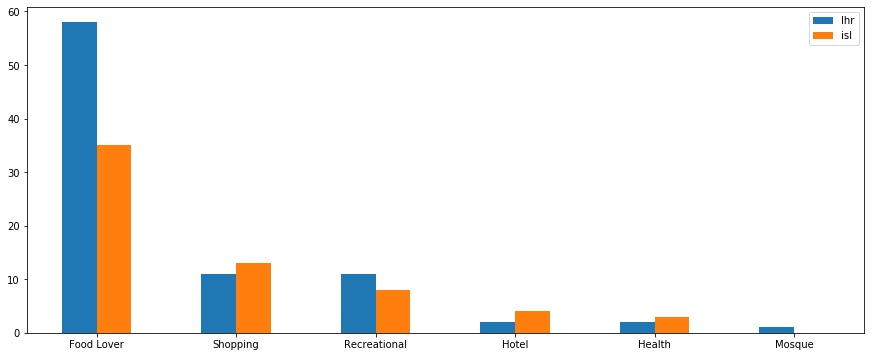

In [117]:
cmp[['lhr','isl']].plot(kind='bar',figsize=(15,6))
plt.xticks(np.arange(6), cmp['index'], rotation=0)
plt.show()

## Insight From Above Graph
- ### Lahore has more Food Lover Spots than Islamabad (As per FourSquare App)
- ### Lahore has more Recreational Spots than Islamabad (As per FourSquare App)

- ### Islamabad is better in hoteling and Health (As per FourSquare App)

- ### Lahore and Islamabad are almost equal for Shopping (As per FourSquare App)

# Clustering the near places to see the different regions

In [128]:
Lah= Lhr_nearby_venues.drop(columns = ['name','categories','address','New Cat'])

In [144]:
Lah.head()

,lat,lng
0,31.591604,74.309481
1,31.587092,74.311538
2,31.588195,74.311354
3,31.523956,74.345706
4,31.519804,74.351510


In [155]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(Lah)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [156]:
pred_L = Lhr_nearby_venues.copy()
pred_L['kmean1'] = kmeans.labels_
pred_L.head()

,name,categories,lat,lng,address,New Cat,kmean1
0,Minar-e-Pakistan,Monument / Landmark,31.591604,74.309481,Circular Rd,Recreational,3
1,Fort Food Street,Food Court,31.587092,74.311538,Fort Rd,Food Lover,3
2,Badshahi Masjid,Mosque,31.588195,74.311354,Shahi Mohalla,Mosque,3
3,Jalal Sons,Department Store,31.523956,74.345706,12-E Main Market,Shopping,0
4,Tuscany Courtyard,Italian Restaurant,31.519804,74.351510,MM Alam Road,Food Lover,0


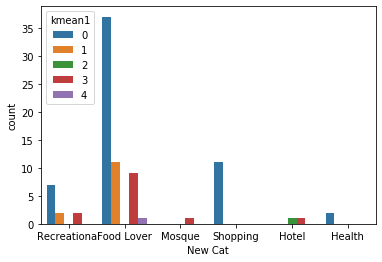

In [158]:
sns.countplot(x='New Cat',hue='kmean1', data= pred_L)

## Insight From Above Graph from LAHORE
    - If you are food lover you may choose to stay in Cluster 0.
    - If you are recreational you may choose Cluster 0.
    - If you love shopping you may choose Cluster 0.
    - If you are health conscious then you may choose 0.
    - If you want to stay in hotel you have to go to cluster 2,3.
   ### So One should choose to live in Cluster 0 for having access to different Categories . (The Blue One)
   ### Lets see the Cluster in Map

In [160]:
# create map
pred= pred_L.copy()
map_clusters_lhr = folium.Map(location=[Lhr_latitude, Lhr_longitude], zoom_start=11)
kclusters=5
# set color scheme for the clusters
'''
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

'''
rainbow=['blue','yellow','green','red','purple']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pred['lat'], pred['lng'], pred['New Cat'], pred['kmean1']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_lhr)
       
map_clusters_lhr

In [141]:
Isl= Isl_nearby_venues.drop(columns = ['name','categories','address','New Cat'])

In [143]:
Isl.head()

,lat,lng
0,33.693070,73.068910
1,33.720508,73.073956
2,33.688942,73.072550
3,33.696279,73.012849
4,33.729388,73.074913


In [145]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(Isl)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [151]:
pred_i = Isl_nearby_venues.copy()
pred_i['kmean1'] = kmeans.labels_
pred_i.head()

,name,categories,lat,lng,address,New Cat,kmean1
0,Pakistan Monument,History Museum,33.693070,73.068910,Islamabad,Recreational,0
1,Burning Brownie Cafe & Bake Shop,Coffee Shop,33.720508,73.073956,"Shop # 66, Beverly Centre",Food Lover,0
2,Lok Virsa Museum,History Museum,33.688942,73.072550,Garden avenue,Recreational,0
3,D.Watson,Pharmacy,33.696279,73.012849,"10th Avenue, F-10 Markaz",Health,3
4,Chaaye Khana,Tea Room,33.729388,73.074913,"Shop # 11, Block-B, United Bakery Plaza, F-6 M...",Food Lover,0


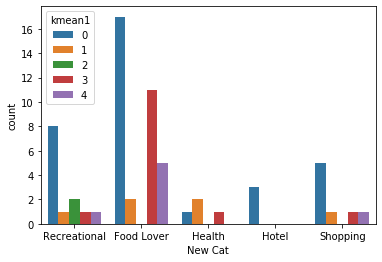

In [152]:
sns.countplot(x='New Cat',hue='kmean1', data= pred_i)

## Insight From Above Graph from ISLAMABAD
    - If you are food lover you may choose to stay in Cluster 0 or 3
    - If you are recreational you may choose Cluster 0.
    - If you love shopping you may choose Cluster 0.
    - If you are health conscious then you may choose 0,1 or 3.
    - If you want to stay in hotel you have to go to cluster 0.
    
   ### One should choose to live in Cluster 0 for having access to different Categories . (The Blue One)
   ### Lets see the Cluster in Map

In [162]:
# create map
pred=pred_i
map_clusters_Isl = folium.Map(location=[Isl_latitude, Isl_longitude], zoom_start=10)
kclusters=5
# set color scheme for the clusters
'''
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
'''
rainbow=['blue','yellow','green','red','purple']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pred['lat'], pred['lng'], pred['New Cat'], pred['kmean1']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_Isl)
       
map_clusters_Isl